# Sinkhorn Divergence Hessians

## Samples two point clouds, computes their ``sinkhorn_divergence``

We show in this [colab](https://colab.research.google.com/drive/1fbO-U3iDZCzTwfKCh0G5DeIcT0xWj2Y1#scrollTo=jzzs0FmbPpvY) how OTT and JAX can be used to compute automatically the Hessian of the Sinkhorn divergence w.r.t. input variables, such as weights ``a`` or locations ``x``. Don't forget to ``!pip install ott-jax`` before running the code below.

In [6]:
import jax
import jax.numpy as jnp

import ott
from ott.tools import sinkhorn_divergence
from ott.geometry import pointcloud
import matplotlib.pyplot as plt

Sample two random point clouds of dimension `dim`

In [7]:
def sample(n, m, dim):
    rngs = jax.random.split(jax.random.PRNGKey(0), 6)
    x = jax.random.uniform(rngs[0], (n, dim))
    y = jax.random.uniform(rngs[1], (m, dim))
    a = jax.random.uniform(rngs[2], (n,)) + 0.1
    b = jax.random.uniform(rngs[3], (m,)) + 0.1
    a = a / jnp.sum(a)
    b = b / jnp.sum(b)
    return a, x, b, y

In [ ]:
a, x, b, y = sample(15, 17, 3)

As usual in JAX, we define a custom loss that outputs the quantity of interest, and is defined using relevant inputs as arguments, i.e. parameters against which we may want to differentiate. We add to `a` and `x` the ``implicit`` auxiliary flag which will be used to switch between unrolling and implicit differentiation of the Sinkhorn algorithm (see this excellent [tutorial](http://implicit-layers-tutorial.org/implicit_functions/) for a deep dive on their differences!)

The loss outputs the Sinkhorn Divergence between two point clouds.

In [9]:
def loss(a, x, implicit):
    return sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud,
        x,
        y,  # this part defines geometry
        a=a,
        b=b,  # this sets weights
        sinkhorn_kwargs={
            "implicit_differentiation": implicit,
            "use_danskin": False,
        },  # to be used by Sinkhorn algorithm.
    ).divergence

Let's parse the three lines in the call to ``sinkhorn_divergence`` above:
- The first one defines the point cloud geometry between ``x`` and ``y`` that will define the cost matrix. Here we could have added details on ``epsilon`` regularization (or scheduler), as well as alternative definitions of the cost function (here assumed by default to be squared Euclidean distance). We stick to the default setting.

- The second one sets the respective weight vectors `a` and `b`. Those are simply two histograms of size ``n`` and ``m``, both sum to 1, in the so-called balanced setting.

- The third one passes on arguments to the three ``sinkhorn`` solvers that will be called, to compare ``x`` with ``y``, ``x`` with ``x`` and ``y`` with ``y`` with their respective weights ``a`` and ``b``. Rather than focusing on the several numerical options available to parmeterize ``sinkhorn``'s behavior, we instruct JAX on how it should differentiate the outputs of the sinkhorn algorithm. The ``use_danskin`` flag specifies whether the outputted potentials should be freezed when differentiating. Since we aim for 2nd order differentiation here, we must set this to ``False`` (if we wanted to compute gradients, ``True`` would have resulted in faster yet almost equivalent computations).

## Computing Hessians

Let's now plot Hessians of this output w.r.t. either ``a`` or ``x``. 

- The Hessian w.r.t. ``a`` will be a $n \times n$ matrix, with the convention that ``a`` has size $n$. 

- Because ``x`` is itself a matrix of 3D coordinates, the Hessian w.r.t. ``x`` will be a 4D tensor of size $n \times 3 \times n \times 3$.

To plot both Hessians, we loop on arg 0 or 1 of ``loss``, and plot all (or part for ``x``) of those Hessians, to check they match:

--- Time: Implicit Hessian w.r.t. a
The slowest run took 1302.43 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 18.8 ms per loop
--- Time: Unrolled Hessian w.r.t. a
The slowest run took 390.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 60.6 ms per loop
--- Time: Implicit Hessian w.r.t. x
The slowest run took 405.75 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 65.6 ms per loop
--- Time: Unrolled Hessian w.r.t. x
The slowest run took 177.86 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 130 ms per loop


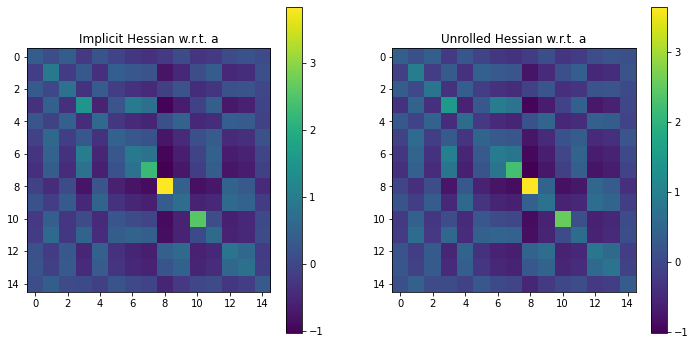

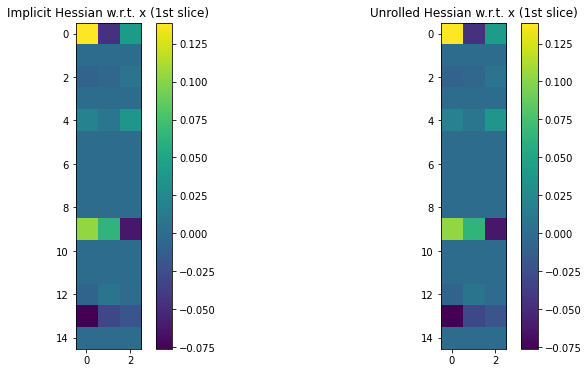

In [17]:
for arg in [0, 1]:
    # Compute Hessians using either unrolling or implicit differentiation.
    hess_loss_imp = jax.jit(jax.hessian(lambda a, x: loss(a, x, True), argnums=arg))
    print("--- Time: Implicit Hessian w.r.t. " + ("a" if arg == 0 else "x"))
    %timeit _ = hess_loss_imp(a, x).block_until_ready()
    hess_imp = hess_loss_imp(a, x)

    hess_loss_back = jax.jit(jax.hessian(lambda a, x: loss(a, x, False), argnums=arg))
    print("--- Time: Unrolled Hessian w.r.t. " + ("a" if arg == 0 else "x"))
    %timeit _ = hess_loss_back(a, x).block_until_ready()
    hess_back = hess_loss_back(a, x)

    # Since we are solving balanced OT problems, Hessians w.r.t. weights are
    # only defined up to the orthogonal space of 1s.
    # For that reason we remove that contribution and check the
    # resulting matrices are equal.
    if arg == 0:
        hess_imp -= jnp.mean(hess_imp, axis=1)[:, None]
        hess_back -= jnp.mean(hess_back, axis=1)[:, None]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    im = ax1.imshow(hess_imp if arg == 0 else hess_imp[0, 0, :, :])
    ax1.set_title("Implicit Hessian w.r.t. " + ("a" if arg == 0 else "x (1st slice)"))
    fig.colorbar(im, ax=ax1)
    im = ax2.imshow(hess_back if arg == 0 else hess_back[0, 0, :, :])
    ax2.set_title("Unrolled Hessian w.r.t. " + ("a" if arg == 0 else "x (1st slice)"))
    fig.colorbar(im, ax=ax2)